In [1]:
from trans import Dataset
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=5000):
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, dim, 2, dtype=torch.float) *
                             -(math.log(10000.0) / dim)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pe', pe)
        self.dim = dim

    def forward(self, emb):
        emb = emb * math.sqrt(self.dim)
        emb = emb + self.pe[:,:emb.size(1),:]
        return emb

In [4]:
data = Dataset('data/transcriptions/train.csv')
words_vocab = data.words_vocab
trans_vocab = data.trans_vocab

In [6]:
batch_size = 32
batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(30, sort=True)

In [8]:
batch_words.size(), batch_trans_in.size(), batch_trans_out.size()

(torch.Size([30, 15]), torch.Size([30, 13]), torch.Size([30, 13]))

In [52]:
model_size   = 64
padding_idx  = 0

embedding    = nn.Embedding(data.words_vocab.vocab_size,
                           model_size,
                           padding_idx=padding_idx).to(device)

pos_encoding = PositionalEncoding(model_size).to(device)

conv1 = nn.Conv1d(model_size, model_size, kernel_size=3, padding=1, stride=1).to(device)

conv2 = nn.Conv1d(model_size // 2, model_size, kernel_size=3, padding=1, stride=1).to(device)

conv3 = nn.Conv1d(model_size // 2, model_size, kernel_size=3, padding=1, stride=1).to(device)


In [53]:
embedded = embedding(batch_words)
embedded = pos_encoding(embedded)

In [54]:
x = embedded.transpose(1, 2)

In [59]:
x = conv1(x)
print(x.size())
x = F.glu(x, dim=1)
print(x.size())
print()

x = conv2(x)
print(x.size())
x = F.glu(x, dim=1)
print(x.size())
print()

x = conv3(x)
print(x.size())

torch.Size([30, 64, 15])
torch.Size([30, 32, 15])

torch.Size([30, 64, 15])
torch.Size([30, 32, 15])

torch.Size([30, 64, 15])


In [693]:
class ConvEncoder(nn.Module):
    def __init__(self, vocab_size, model_size, num_layers, pad_idx, norm_const=0.5):
        super(ConvEncoder, self).__init__()
        
        self.pad_idx = pad_idx
        self.norm_const = norm_const
        
        self.embedding    = nn.Embedding(data.words_vocab.vocab_size,
                           model_size,
                           padding_idx=padding_idx).to(device)

        self.pos_encoding = PositionalEncoding(model_size).to(device)

        self.convs = nn.ModuleList([
            nn.Conv1d(model_size, model_size * 2, kernel_size=3, padding=1, stride=1).to(device)        
            for _ in range(num_layers)
        ])
        
        self.linear_in = nn.Linear(model_size, model_size)
        self.linear_out = nn.Linear(model_size, model_size)
        
    def forward(self, source):
        '''
        Inputs:
            source: (batch_size x seq_len)
        Outputs:
            x: (batch_size x seq_len x model_size)
            y: (batch_size x seq_len x model_size)
            mask: (batch x 1 x seq_len)
        '''
        mask = (source == self.pad_idx)
        mask = mask.unsqueeze(1) 
        
        embedded = self.embedding(source)
        embedded = self.pos_encoding(embedded)
        
        x = self.linear_in(embedded)
        x = embedded.transpose(1, 2)
        
        res = x
        for conv in self.convs:
            x.masked_fill_(mask, 1e-18) #small number
            x = conv(x)
            x = F.glu(x, dim=1)
            x = (x + res) * math.sqrt(self.norm_const)
            res = x
            
        
        x = x.transpose(1, 2)
        x = self.linear_out(x)
        y = (x + embedded) * math.sqrt(self.norm_const)
        
        return x, y, mask

    
class MultiStepAttention(nn.Module):
    def __init__(self, in_channels, model_size, norm_const=0.5):
        super(MultiStepAttention, self).__init__()
        
        self.in_channels = in_channels
        self.model_size = model_size
        self.norm_const = norm_const
        
        self.linear_in = nn.Linear(in_channels, model_size)
        self.linear_out = nn.Linear(model_size, in_channels)
        
    def forward(self, encoder_outputs, encoder_emb, decoder_outputs, decoder_emb, mask = None):
        '''
        Inputs:
            encoder_outputs: (batch_size x enc_seq_len x model_size)
            encoder_emb: (batch_size x enc_seq_len x model_size)
            decoder_outputs : (batch_size x dec_seq_len x model_size)
            decoder_emb: (batch_size x dec_seq_len x model_size)
            mask: batch x 1 x enc_seq_len
        '''
        
        res   = decoder_outputs
#         print(decoder_outputs.size(), 'decoder out')
#         print(decoder_emb.size(), 'emb')
#         print(self.linear_in(decoder_outputs).size(), 'linear')
        query = (self.linear_in(decoder_outputs) + decoder_emb) * math.sqrt(self.norm_const)

        
        logits = decoder_outputs.matmul(encoder_outputs.transpose(1, 2))
#         print(logits.size(), 'logits')
        if mask is not None:
            logits.masked_fill_(mask, -1e18)
            
        weights = F.softmax(logits, dim=-1)
#         print(weights.size(), 'weights')
        
        output = weights.matmul(encoder_outputs + encoder_emb)
        output = (self.linear_out(output) + decoder_outputs) * math.sqrt(self.norm_const)

#         print(output.size(), 'output')
        return output, weights
        
        
class ConvDecoder(nn.Module):
    def __init__(self, vocab_size, model_size, pad_idx, bottle_size, num_layers, norm_const=0.5):
        super(ConvDecoder, self).__init__()
        
        self.pad_idx = pad_idx
        self.norm_const = norm_const
        self.vocab_size = vocab_size
        
        self.embedding    = nn.Embedding(vocab_size,
                           model_size,
                           padding_idx=padding_idx).to(device)

        self.pos_encoding = PositionalEncoding(model_size)
    
        self.convs = nn.ModuleList([
            nn.Conv1d(model_size, model_size * 2, kernel_size=3, padding=0, stride=1).to(device)        
            for _ in range(num_layers)
        ])
        
        self.attns = nn.ModuleList([
                        MultiStepAttention(model_size, model_size)
                        for _ in range(num_layers)
        ])
        
        self.linear_in = nn.Linear(model_size, model_size)
        self.linear_out = nn.Linear(model_size, model_size)
        
        self.linear_logits = nn.Linear(model_size, vocab_size)
        
        
        
    def forward(self, target, encoder_outputs, encoder_emb, encoder_mask):
        '''
        Input:
            target: (batch_size x seq_len)
            encoder_outputs: (batch_size x seq_len x model_size)
            encoder_emb: (batch_size x seq_len x model_size)
            encoder_mask: (batch x 1 x seq_len)       
        
        '''
        target = F.pad(target, (2, 0))
        mask = (target == self.pad_idx)
        mask = mask.unsqueeze(1)#.transpose(1, 2)
        
        embedded = self.embedding(target)
        embedded = self.pos_encoding(embedded)
               
        x = self.linear_in(embedded)
        x = x.transpose(1, 2)
        

        for att, conv in zip(self.attns, self.convs): 
            x.masked_fill_(mask, 0) #small number
            x = F.pad(x, (2, 0))
            
            x = conv(x)
            x = F.glu(x, dim=1)
            
            res = x
            x, _ = att(encoder_outputs, encoder_emb, x.transpose(1, 2), embedded, encoder_mask)
            x = (x + res.transpose(1, 2)) * math.sqrt(self.norm_const)
                           
            x = x.transpose(1, 2)

        
        x = x.transpose(1, 2)
        out = self.linear_logits(x[:, 2:, :])       
        logits = out.view(-1, self.vocab_size)

        return logits    

In [694]:
decoder = ConvDecoder(data.words_vocab.vocab_size, model_size, 0,  3, 3).to(device)

In [695]:
model_size = 64
num_heads   = 8
num_layers = 2
ff_size = 128

encoder = ConvEncoder(data.words_vocab.vocab_size, model_size, 3, 0).to(device)

decoder = ConvDecoder(data.trans_vocab.vocab_size, model_size, 0,  3, 3).to(device)

criterion = nn.CrossEntropyLoss()
model = Model(data, encoder, decoder, model_size).to(device)
optimizer = optim.Adam(model.parameters())

In [696]:
class Model(nn.Module):
    def __init__(self, dataset, encoder, decoder, hidden_size):
        super(Model, self).__init__()
        self.dataset = dataset
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_words, batch_trans_in, source_lens = None, mask = None):
        
        encoder_outputs, encoder_emb, enc_mask = self.encoder(batch_words)
        out = self.decoder(batch_trans_in, encoder_outputs, encoder_emb, enc_mask)
        
        return out

In [697]:
class Trainer:
    def __init__(self, dataset, model, optimizer, criterion, batch_size):
        
        
        self.dataset = dataset
        self.train_losses = []
        self.val_losses = []
        self.batch_size = batch_size
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        
               
    def train(self, n_epochs):
        
        mask_words = None
        for epoch in range(n_epochs):

            for batch_idx in range(len(self.dataset)//self.batch_size):

                batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = self.dataset.get_batch(32, sort = True)
                mask_words  = batch_words != 0
                
                logits = self.model(batch_words, batch_trans_in, words_lens, mask_words)

                batch_trans_out = batch_trans_out.view(-1)  
                mask = batch_trans_out != self.dataset.trans_vocab.pad_idx
                

                loss = self.criterion(logits[mask], batch_trans_out[mask])

                self.optimizer.zero_grad()

                loss.backward()

                self.optimizer.step()


                self.train_losses.append(loss.item())
                
                if batch_idx % 200 == 0:
                    val_loss = self.eval_()
                    self.val_losses.append(val_loss.item())
                    self.plot(epoch, batch_idx, self.train_losses, self.val_losses)
                  
        
    def eval_(self):
        
        val_words, val_trans_in, val_trans_out, val_words_lens, val_trans_lens = self.dataset.get_batch(32, sort = True, val = True)
        val_mask = val_words != 0
        logits = self.model(val_words, val_trans_in, val_words_lens, val_mask)
        val_trans_out = val_trans_out.view(-1)                

        mask = val_trans_out != trans_vocab.pad_idx

        loss = self.criterion(logits[mask], val_trans_out[mask])

        return loss
        
    def plot(self, epoch, batch_idx, train_losses, val_losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, train_losses[-1]))
        plt.plot(train_losses)
        plt.subplot(132)
        plt.title('epoch %s. | loss: %s' % (epoch, val_losses[-1]))
        plt.plot(val_losses)
        plt.show()  

In [698]:
trainer = Trainer(data, model, optimizer, criterion, batch_size = 32)

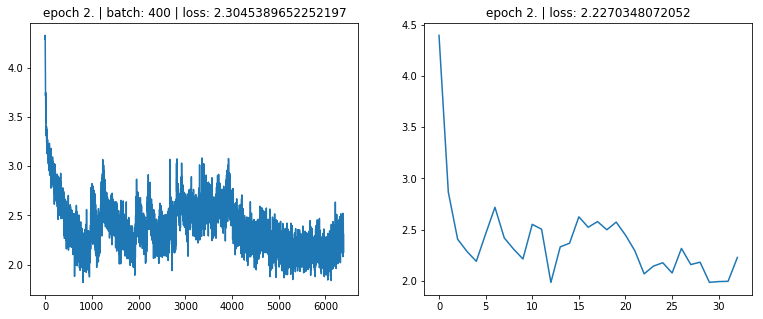

KeyboardInterrupt: 

In [699]:
trainer.train(10)

In [675]:
def translate(model, sos_idx, eos_idx, batch_words):
    '''
    Inputs:
        batch_words: (1 x seq_len)
    Outputs:
        tokens: example - [45, 30, 122, 4, 8, 5]
    '''
    encoder_outputs, encoder_embedded, mask = model.encoder(batch_words.to(device))
    generated_word = [sos_idx]
    seq_len = batch_words.size(1)

    for char in range(seq_len):
        inp_tensor = torch.LongTensor([generated_word]).to(device)
        logits = model.decoder(inp_tensor, encoder_outputs, encoder_embedded, mask)
#         logits = logits.squeeze(0)
        logits = F.softmax(logits, dim=-1)

#         print(logits[-1, :])
        prob_next_token, next_token = logits[-1, :].max(0)
#         print(next_token.item())
        generated_word.append(next_token.item())
        if next_token is eos_idx:
            break
    return generated_word

In [676]:
def _print(val, model):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(1, sort=True, val=val)
    batch_words     = batch_words.to(device)
    batch_trans_out = batch_trans_out.to(device)


    inp = translate(model, data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words)
            
    tokens = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
                                                                       data.trans_vocab.eos_idx,
                                                                       data.trans_vocab.pad_idx]]
    print('Src: ', ''.join([data.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    print('Real:', ''.join([data.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [data.trans_vocab.sos_idx,
                                                                            data.trans_vocab.eos_idx,
                                                                            data.trans_vocab.pad_idx]]))

In [700]:
for _ in range(10):
    _print(True, model)
    print()

Src:  DREPUNG
Pred: DREHPAH
Real: DREYPAONG

Src:  TELEPATHY
Pred: TEHLIHIY
Real: TAHLEHPAHTHIY

Src:  IDENTIFICATIONS
Pred: IHFSIHKIHNIYIHKIHNIY
Real: AYDEHNAHFAHKEYSHAHNZ

Src:  EXHIBITOR
Pred: EHKEHSS
Real: IHGZIHBAHTER

Src:  PROTRUDE
Pred: PRAASS
Real: PROWTRUWD

Src:  MARYLEBONE
Pred: MAARIYAHNIY
Real: MERLAHBOWN

Src:  ADERMAN
Pred: VREHNAH
Real: AEDERMAHN

Src:  TEHRANS
Pred: TEHRAHN
Real: TEYRAANZ

Src:  HILLSBORO
Pred: HHLAASSS
Real: HHIHLZBEROW

Src:  WENDS
Pred: WEHSS
Real: WEHNDZ

